<a href="https://colab.research.google.com/github/Blandalytics/3D_wOBA/blob/main/3d_wOBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MLB Blog on xwOBA

https://technology.mlblogs.com/an-introduction-to-expected-weighted-on-base-average-xwoba-29d6070ba52b

# Import and Load

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
from google.colab import auth
auth.authenticate_user()

In [5]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

# Yay Google integrations
import gspread
from google.auth import default
from gspread_dataframe import set_with_dataframe
creds, _ = default()
gc = gspread.authorize(creds)

In [6]:
%cd /gdrive/MyDrive/PL_Stats

/gdrive/MyDrive/PL_Stats


In [7]:
# Load trained/fitted models

# Right-handed KNN
with open('3D wOBA/3d_wOBA_R_knn.pkl', 'rb') as f:
    knn_clf_R = pickle.load(f)

# Left-Handed KNN
with open('3D wOBA/3d_wOBA_L_knn.pkl', 'rb') as f:
    knn_clf_L = pickle.load(f)

# XGBoost
with open('3D wOBA/3d_wOBA_xgb.pkl', 'rb') as f:
    xgb_clf = pickle.load(f)

In [8]:
# Target Google Sheet
xwOBA_sheet = gc.open('3D wOBAcon')

In [9]:
# Load Batter Names from MLB ID
name_df = pd.read_csv('https://docs.google.com/spreadsheets/d/1JgczhD5VDQ1EiXqVG-blttZcVwbZd5_Ne_mefUGwJnk/export?format=csv&gid=0')
name_df = name_df[['MLBID','MLBNAME']].dropna().astype({'MLBID':'int'}).set_index('MLBID').to_dict()['MLBNAME']

In [10]:
# Load previously scraped data (credit: pybaseball's scraper!)
pitch_data = pd.concat([pd.read_parquet('PLV/Pitch Data (2017-2021).parquet.gzip'),
                        pd.read_parquet('PLV/Pitch Data (2022).parquet.gzip')], 
                       ignore_index=True)
pitch_data.shape

(3987304, 92)

## Generate Spray Angle

0 is Pulled along the foul line, 90 is down the Opposite field foul line

In [11]:
# Generat Spray Angle
home_plate = {'x':125,'y':-200} #plate coords
pitch_data['hc_y'] = -pitch_data['hc_y'] # Have homeplate be at the bottom of the plot 

pitch_data['tan_value'] = None
pitch_data.loc[pitch_data['hc_y'].notna(),'tan_value'] = pitch_data.loc[pitch_data['hc_y'].notna(),'hc_y'].sub(home_plate['y']).div(abs(pitch_data.loc[pitch_data['hc_y'].notna(),'hc_x'].sub(home_plate['x'])))

pitch_data['spray_deg'] = None
pitch_data.loc[(pitch_data['hc_x']>=125) &
               (pitch_data['stand']=='L'),'spray_deg'] = pitch_data.loc[(pitch_data['hc_x']>=125) &
                                                                         (pitch_data['stand']=='L'),'tan_value'].apply(lambda x: math.degrees(math.atan(x))-45)
pitch_data.loc[(pitch_data['hc_x']<125) &
               (pitch_data['stand']=='L'),'spray_deg'] = pitch_data.loc[(pitch_data['hc_x']<125) &
                                                                         (pitch_data['stand']=='L'),'tan_value'].apply(lambda x: 135-math.degrees(math.atan(x)))

pitch_data.loc[(pitch_data['hc_x']>=125) &
               (pitch_data['stand']=='R'),'spray_deg'] = pitch_data.loc[(pitch_data['hc_x']>=125) &
                                                                         (pitch_data['stand']=='R'),'tan_value'].apply(lambda x: 135-math.degrees(math.atan(x)))
pitch_data.loc[(pitch_data['hc_x']<125) &
               (pitch_data['stand']=='R'),'spray_deg'] = pitch_data.loc[(pitch_data['hc_x']<125) &
                                                                         (pitch_data['stand']=='R'),'tan_value'].apply(lambda x: math.degrees(math.atan(x))-45)

pitch_data['hc_y'] = -pitch_data['hc_y'] # Revert to original Y coords 
pitch_data['spray_deg'] = pitch_data['spray_deg'].astype('float')

# Train Models

In [22]:
# Model data
xwOBA_df = (
    pitch_data
    .loc[(pitch_data['game_type']=='R') & # Regular Season only
         pitch_data['spray_deg'].notna() & # Need Spray Angle
         pitch_data['launch_angle'].notna() & # Need Launch Angle
         pitch_data['launch_speed'].notna(), # Need Exit Velo
         ['stand','spray_deg', 'launch_angle','launch_speed', # Model columns
          'estimated_woba_using_speedangle','woba_value',  # Comparison columns
          'batter','game_year','events','bb_type']] # Other Columns
    .assign(Batter=lambda x: x.batter.map(name_df)) # Helpful to have names
    .rename(columns={'woba_value':'wOBA',
                     'estimated_woba_using_speedangle':'xwOBA',
                     'game_year':'Season'})
    .copy()
    )

xwOBA_df['stand_cat'] = 0
xwOBA_df.loc[xwOBA_df['stand']=='R','stand_cat'] = 1

xwOBA_df = xwOBA_df.astype({
    'launch_angle':'int',
    'launch_speed':'float'
})

# Remove autofilled speed/angle combinations
# https://tht.fangraphs.com/43416-2/ 
xwOBA_df['no_null_mask'] = 0
xwOBA_df.loc[(xwOBA_df['bb_type']=='popup') &
             (xwOBA_df['launch_speed']==80) &
             (xwOBA_df['launch_angle']==69),'no_null_mask'] = 1
xwOBA_df.loc[(xwOBA_df['bb_type']=='ground_ball') &
             (xwOBA_df['launch_speed']==82.9) &
             (xwOBA_df['launch_angle']==-21),'no_null_mask'] = 1

In [30]:
wOBA_cats = {
    0:0,
    0.9:1,
    1.25:2,
    1.6:3,
    2:4
}

target = 'woba_value_cat'
xwOBA_df[target] = xwOBA_df['wOBA'].map(wOBA_cats).astype(int)

# Previously tuned hyperparams
parameters_knn = {
    'n_neighbors': 100,
    'leaf_size': 20,
    'p': 1,
    'weights': 'uniform',
    'metric': 'minkowski'
}

parameters_xgb = {
    'n_estimators':400,
    'seed_num':12,
    'objective':'multi:softprob',
    'max_depth': 6, 
    'min_child_weight': 4,
    'gamma':0,
    'colsample_bytree': 0.9, 
    'subsample': 0.9,
    'alpha':10,
    'learning_rate':0.2
}

## KNN Classifier

In [25]:
knn_clf = KNeighborsClassifier(**parameters_knn)

for handedness in ['R','L']:
  temp_df = xwOBA_df.loc[(xwOBA_df['stand']==handedness) &
                         (xwOBA_df['no_null_mask']==0)].copy()
  knn_clf.fit(temp_df[['spray_deg','launch_angle','launch_speed']],
              temp_df[target])
  # Save Model
  #with open('3D wOBA/3d_wOBA_{}_knn.pkl'.format(handedness), 'wb') as f:
  #  pickle.dump(knn_clf, f)
  
  xwOBA_df.loc[(xwOBA_df['stand']==handedness),['out_knn','single_knn','double_knn','triple_knn','home_run_knn']] = knn_clf.predict_proba(xwOBA_df.loc[(xwOBA_df['stand']==handedness),['spray_deg','launch_angle','launch_speed']])

xwOBA_df['3d_wOBA_knn'] = xwOBA_df['single_knn']*0.9 + xwOBA_df['double_knn']*1.25 + xwOBA_df['triple_knn']*1.6 + xwOBA_df['home_run_knn']*2

In [71]:
xwOBA_df[['out_knn','single_knn','double_knn','triple_knn','home_run_knn','wOBA','wOBA','xwOBA','3d_wOBA_knn']].describe().round(4)

,out_knn,single_knn,double_knn,triple_knn,home_run_knn,wOBA,wOBA,xwOBA,3d_wOBA_knn
count,652780.0000,652780.0000,652780.0000,652780.0000,652780.0000,652780.0000,652780.0000,652780.0000,652780.0000
mean,0.6575,0.2244,0.0657,0.0060,0.0464,0.3862,0.3862,0.3672,0.3866
std,0.3239,0.2658,0.1511,0.0165,0.1709,0.5814,0.5814,0.3878,0.4326
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.3900,0.0100,0.0000,0.0000,0.0000,0.0000,0.0000,0.0770,0.0630
50%,0.7800,0.1100,0.0100,0.0000,0.0000,0.0000,0.0000,0.2300,0.2160
75%,0.9400,0.3600,0.0400,0.0000,0.0000,0.9000,0.9000,0.5530,0.6140
max,1.0000,1.0000,1.0000,0.2600,1.0000,2.0000,2.0000,2.0640,2.0000


## XGBoost Classifier

In [31]:
# xgboost goes brrrrr
X_train, X_test, y_train, y_test = train_test_split(
    xwOBA_df.loc[(xwOBA_df['no_null_mask']==0),
                 ['stand_cat','spray_deg','launch_angle','launch_speed']], 
    xwOBA_df.loc[(xwOBA_df['no_null_mask']==0),
                 target],
    test_size=0.25, 
    random_state = seed_num)

xgb_clf = XGBClassifier(**parameters_xgb)

xgb_clf.fit(X_train,
            y_train)

# Save Model
#with open('3D wOBA/3d_wOBA_xgb.pkl', 'wb') as f:
#    pickle.dump(xgb_clf, f)

xwOBA_df[['out_xgb','single_xgb','double_xgb','triple_xgb','home_run_xgb']] = xgb_clf.predict_proba(xwOBA_df[['stand_cat','spray_deg','launch_angle','launch_speed']])

xwOBA_df['3d_wOBA_xgb'] = xwOBA_df['single_xgb']*0.9 + xwOBA_df['double_xgb']*1.25 + xwOBA_df['triple_xgb']*1.6 + xwOBA_df['home_run_xgb']*2

In [70]:
xwOBA_df[['out_xgb','single_xgb','double_xgb','triple_xgb','home_run_xgb','wOBA','xwOBA','3d_wOBA_xgb']].describe().round(4)

,out_xgb,single_xgb,double_xgb,triple_xgb,home_run_xgb,wOBA,xwOBA,3d_wOBA_xgb
count,652780.0000,652780.0000,652780.0000,652780.0000,652780.0000,652780.0000,652780.0000,652780.0000
mean,0.6578,0.2228,0.0661,0.0059,0.0475,0.3862,0.3672,0.3875
std,0.3295,0.2696,0.1577,0.0175,0.1791,0.5814,0.3878,0.4446
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.3843,0.0127,0.0015,0.0000,0.0000,0.0000,0.0770,0.0606
50%,0.7950,0.1009,0.0056,0.0002,0.0000,0.0000,0.2300,0.2015
75%,0.9381,0.3473,0.0341,0.0032,0.0001,0.9000,0.5530,0.6177
max,1.0000,0.9960,0.9972,0.8938,1.0000,2.0000,2.0640,2.0000


## Group Seasons

In [34]:
batter_df = (
    xwOBA_df
    .groupby(['Season',
              'Batter'],as_index=False)
    [['wOBA','xwOBA','3d_wOBA_knn','3d_wOBA_xgb','launch_angle']]
    .agg({
        'wOBA':'mean',
        'xwOBA':'mean',
        '3d_wOBA_knn':'mean',
        '3d_wOBA_xgb':'mean',
        'launch_angle':'count'
    })
    .rename(columns={'launch_angle':'BBE'})
    .sort_values(['Batter','Season'])
    .reset_index(drop=True)
    .copy()
)

In [35]:
# Add next year's values, for checking predictiveness
for stat in ['BBE','wOBA']:
  batter_df[stat+'_y+1'] = batter_df[stat].shift(-1)
  batter_df.loc[(batter_df['Batter']!=batter_df['Batter'].shift(-1)) |
                ((batter_df['Season']+1)!=batter_df['Season'].shift(-1)),stat+'_y+1'] = None

# Ensemble weighting
find best combination of KNN model and XGBoost model that minimizes the quadratic mean of current & next year wOBA errors

In [37]:
def model_ensemble(comp_stat,comp_stat_2,model_1_pred,model_2_pred,df=batter_df):
  print('Predicting '+str(comp_stat)+' & '+str(comp_stat_2))
  temp_df = df[[comp_stat,comp_stat_2,model_1_pred,model_2_pred]].dropna().copy()
  
  best_error = np.infty
  best_weight = 0
  for weight in np.linspace(0,1,1001): # for every 0.1% weight, compare error
    temp_df['ensemble_pred'] = weight*temp_df[model_1_pred] + (1-weight)*temp_df[model_2_pred]
    error_1 = temp_df['ensemble_pred'].sub(temp_df[comp_stat]).abs().mean()
    error_2 = temp_df['ensemble_pred'].sub(temp_df[comp_stat_2]).abs().mean()
    error = (error_1**2+error_2**2)**0.5

    if error < best_error:
      best_error = error
      best_weight = weight
    if weight==0:
      print(model_2_pred+' Error: {}'.format(round(error,4)))
    if weight==1:
      print(model_1_pred+' Error: {}'.format(round(error,4)))
  print('Best Error: {}'.format(round(best_error,4)))
  print('Best Weight: {}'.format(best_weight))
  return best_weight

In [38]:
ensemble_weight = model_ensemble('wOBA','wOBA_y+1',
                                 model_1_pred='3d_wOBA_knn',
                                 model_2_pred='3d_wOBA_xgb')

Predicting wOBA & wOBA_y+1
3d_wOBA_xgb Error: 0.0982
3d_wOBA_knn Error: 0.0982
Best Error: 0.098
Best Weight: 0.444


# Apply Models

## KNN

In [44]:
def add_3d_wOBA_knn(df,models=[knn_clf_R,knn_clf_L]):
  for handedness in ['R','L']:
    knn_clf = models[0] if handedness=='R' else models[1]
    df.loc[df['stand']==handedness,['out_knn','single_knn','double_knn','triple_knn','home_run_knn']] = knn_clf.predict_proba(df.loc[df['stand']==handedness,['spray_deg','launch_angle','launch_speed']])
  return df['single_knn']*0.9 + df['double_knn']*1.25 + df['triple_knn']*1.6 + df['home_run_knn']*2

xwOBA_df['3d_wOBA_knn'] = add_3d_wOBA_knn(xwOBA_df)

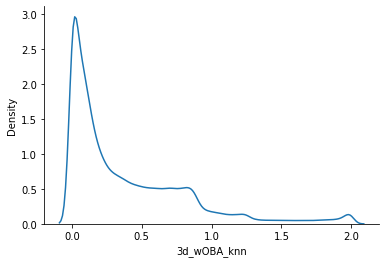

In [46]:
# KNN Distribution
sns.kdeplot(x=xwOBA_df['3d_wOBA_knn'])
sns.despine()

## XGB

In [47]:
def add_3d_wOBA_xgb(df,model=xgb_clf):
  df['stand_cat'] = 0
  df.loc[df['stand']=='R','stand_cat'] = 1

  df = df.astype({
      'launch_angle':'int',
      'launch_speed':'float'
  })

  df[['out_xgb','single_xgb','double_xgb','triple_xgb','home_run_xgb']] = model.predict_proba(df[['stand_cat','spray_deg','launch_angle','launch_speed']])
  return df['single_xgb']*0.9 + df['double_xgb']*1.25 + df['triple_xgb']*1.6 + df['home_run_xgb']*2

xwOBA_df['3d_wOBA_xgb'] = add_3d_wOBA_xgb(xwOBA_df)

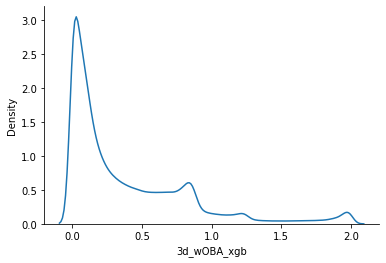

In [48]:
# XGB Distribution
sns.kdeplot(x=xwOBA_df['3d_wOBA_xgb'])
sns.despine()

## Combined

In [50]:
def combine_3d_wOBA(df,model_weight=ensemble_weight):
  df['3D wOBA'] = df['wOBA'].copy() # Baseline is wOBA (non-BBE values)
  df.loc[df['3d_wOBA_knn'].notna() &
         df['3d_wOBA_xgb'].notna(),'3D wOBA'] = model_weight * df.loc[df['3d_wOBA_knn'].notna() &
                                                                      df['3d_wOBA_xgb'].notna(),'3d_wOBA_knn'] + (1-model_weight) * df.loc[df['3d_wOBA_knn'].notna() &
                                                                                                                                           df['3d_wOBA_xgb'].notna(),'3d_wOBA_xgb']

  return df['3D wOBA']
xwOBA_df['3D wOBA'] = combine_3d_wOBA(xwOBA_df)

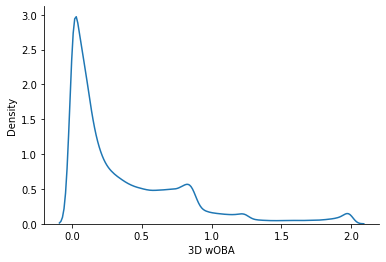

In [51]:
# 3D wOBA distribution
sns.kdeplot(x=xwOBA_df['3D wOBA'])
sns.despine()

In [53]:
# Fill non_BBE xwOBA with wOBA
xwOBA_df['xwOBA'] = xwOBA_df['xwOBA'].fillna(xwOBA_df['wOBA'])

# Analyze Results

In [55]:
batter_df = (
    xwOBA_df
    .groupby(['Season',
              'Batter'],as_index=False)
    [['wOBA','xwOBA','3d_wOBA_knn','3d_wOBA_xgb','3D wOBA','launch_angle']]
    .agg({
        'wOBA':'mean',
        'xwOBA':'mean',
        '3d_wOBA_knn':'mean',
        '3d_wOBA_xgb':'mean',
        '3D wOBA':'mean',
        'launch_angle':'count'
    })
    .rename(columns={'launch_angle':'BBE'})
    .sort_values(['Batter','Season'])
    .reset_index(drop=True)
    .sort_values('3D wOBA', ascending=False)
    .query('BBE>=200') # BBE min
    .copy()
)

batter_df['Expectation Diff'] = batter_df['xwOBA'].sub(batter_df['3D wOBA']) # comparison of expected stats
batter_df['3D Diff'] = batter_df['wOBA'].sub(batter_df['3D wOBA']) # comparison to actual results

# Update Google Sheet
#set_with_dataframe(xwOBA_sheet.get_worksheet(0),
#                   batter_df[['Batter','Season','BBE','wOBA','xwOBA','3D wOBA',
#                              'Expectation Diff','3D Diff']],
#                   resize=True)

In [56]:
# Best 3D wOBA season
batter_df.loc[batter_df['3D wOBA']==batter_df['3D wOBA'].max()]

,Season,Batter,wOBA,xwOBA,3d_wOBA_knn,3d_wOBA_xgb,3D wOBA,BBE,Expectation Diff,3D Diff
32,2022,Aaron Judge,0.594962,0.602756,0.637049,0.651951,0.645335,397,-0.042579,-0.050372


In [57]:
# Worst 3D wOBA season
batter_df.loc[batter_df['3D wOBA']==batter_df['3D wOBA'].min()]

,Season,Batter,wOBA,xwOBA,3d_wOBA_knn,3d_wOBA_xgb,3D wOBA,BBE,Expectation Diff,3D Diff
1172,2018,Delino DeShields,0.285957,0.246443,0.253132,0.253283,0.253216,235,-0.006774,0.032741


In [58]:
# Individual Batter comparison
batter_df.loc[batter_df['Batter']=='Alex Bregman'].drop(columns=['Expectation Diff','3D Diff']).sort_values('Season').round(3)

,Season,Batter,wOBA,xwOBA,3d_wOBA_knn,3d_wOBA_xgb,3D wOBA,BBE
184,2017,Alex Bregman,0.389,0.362,0.376,0.371,0.373,439
185,2018,Alex Bregman,0.405,0.359,0.383,0.386,0.385,486
186,2019,Alex Bregman,0.429,0.351,0.396,0.395,0.395,467
188,2021,Alex Bregman,0.357,0.337,0.381,0.378,0.379,298
189,2022,Alex Bregman,0.35,0.339,0.403,0.399,0.401,480


In [59]:
print('3D wOBAcon Overperformers')
(batter_df
 .sort_values('3D Diff', ascending=False)
 .drop(columns=['Expectation Diff'])
 .head(5)
 .round(3)
 )

3D wOBAcon Overperformers


,Season,Batter,wOBA,xwOBA,3d_wOBA_knn,3d_wOBA_xgb,3D wOBA,BBE,3D Diff
1486,2019,Fernando Tatis Jr,0.578,0.446,0.470,0.479,0.475,225,0.103
3368,2017,Nick Williams,0.488,0.421,0.395,0.398,0.397,216,0.091
4220,2017,Trevor Story,0.48,0.404,0.388,0.393,0.391,294,0.089
803,2017,Charlie Blackmon,0.507,0.41,0.412,0.422,0.418,485,0.089
3156,2017,Michael Taylor,0.515,0.416,0.432,0.429,0.430,251,0.084


In [60]:
print('3D wOBAcon Underperformers')
(batter_df
 .sort_values('3D Diff')
 .drop(columns=['Expectation Diff'])
 .head(5)
 .round(3)
 )

3D wOBAcon Underperformers


,Season,Batter,wOBA,xwOBA,3d_wOBA_knn,3d_wOBA_xgb,3D wOBA,BBE,3D Diff
2633,2022,Kole Calhoun,0.342,0.404,0.444,0.443,0.444,255,-0.102
1575,2022,Gary Sanchez,0.363,0.416,0.454,0.456,0.455,287,-0.092
1571,2018,Gary Sanchez,0.346,0.415,0.431,0.443,0.438,222,-0.091
2415,2021,Josh Donaldson,0.409,0.451,0.496,0.499,0.498,350,-0.089
3803,2022,Ryan Mountcastle,0.392,0.461,0.477,0.480,0.479,404,-0.086


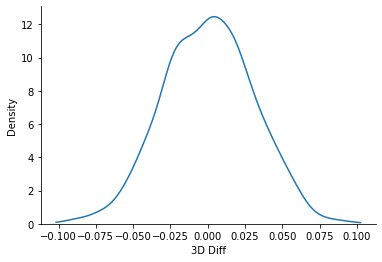

In [61]:
# Residual comparison
sns.kdeplot(x=batter_df['3D Diff'],
            cut=0)
sns.despine()

In [65]:
# Event Comparisons
(xwOBA_df
 .loc[xwOBA_df['events'].isin(
     ['double','double_play','field_error','field_out','fielders_choice',
      'fielders_choice_out','grounded_into_double_play','home_run','sac_bunt',
      'sac_bunt_double_play','sac_fly','sac_fly_double_play','single','triple',
      'triple_play'])] # Relevant events (rel-events?)
 .groupby('events')
 [['wOBA','xwOBA','3D wOBA']]
 .mean()
 .round(3)
 )

,wOBA,xwOBA,3D wOBA
events,,,
double,1.25,0.671,0.898
double_play,0.0,0.425,0.389
field_error,0.9,0.21,0.225
field_out,0.0,0.213,0.181
fielders_choice,0.896,0.181,0.194
fielders_choice_out,0.0,0.174,0.181
grounded_into_double_play,0.0,0.209,0.194
home_run,2.0,1.355,1.590
sac_bunt,0.062,0.209,0.198


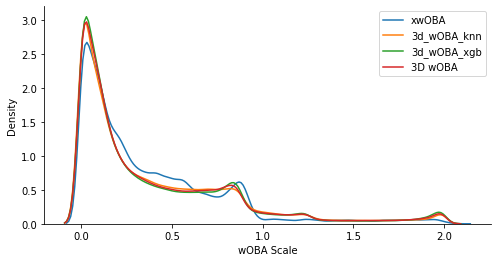

In [66]:
# Model Distributions on BBE
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(x=xwOBA_df['xwOBA'])
sns.kdeplot(x=xwOBA_df['3d_wOBA_knn'])
sns.kdeplot(x=xwOBA_df['3d_wOBA_xgb'])
sns.kdeplot(x=xwOBA_df['3D wOBA'])
ax.set(xlabel='wOBA Scale')
ax.legend(['xwOBA','3d_wOBA_knn','3d_wOBA_xgb','3D wOBA'])
sns.despine()

In [67]:
# Best batters (2017-2022)
all_seasons_df = (
    xwOBA_df
    .groupby('Batter',as_index=False)
    [['wOBA','xwOBA','3D wOBA','launch_angle']]
    .agg({
        'wOBA':'mean',
        'xwOBA':'mean',
        '3D wOBA':'mean',
        'launch_angle':'count'
    })
    .rename(columns={'launch_angle':'BBE'})
    .query('BBE >=500')
    .sort_values('3D wOBA', ascending=False)
    [['Batter','BBE','wOBA','xwOBA','3D wOBA']]
)
all_seasons_df['Expectation Diff'] = all_seasons_df['xwOBA'].sub(all_seasons_df['3D wOBA'])
all_seasons_df['3D Diff'] = all_seasons_df['wOBA'].sub(all_seasons_df['3D wOBA'])
#set_with_dataframe(xwOBA_sheet.get_worksheet(1),all_seasons_df, resize=True)

In [69]:
all_seasons_df.round(3)

,Batter,BBE,wOBA,xwOBA,3D wOBA,Expectation Diff,3D Diff
12,Aaron Judge,1667,0.561,0.568,0.574,-0.006,-0.013
1105,Mike Trout,1508,0.539,0.507,0.524,-0.016,0.015
1554,Yordan Alvarez,988,0.496,0.513,0.523,-0.011,-0.028
522,Fernando Tatis Jr,717,0.547,0.497,0.522,-0.025,0.025
757,Joey Gallo,1224,0.493,0.502,0.513,-0.01,-0.02
...,...,...,...,...,...,...,...
830,Jose Reyes,583,0.319,0.285,0.299,-0.014,0.019
1424,Tony Kemp,1225,0.312,0.272,0.295,-0.023,0.017
1266,Ronal Torreyes,639,0.322,0.259,0.293,-0.034,0.029
1153,Nicky Lopez,1262,0.301,0.27,0.293,-0.022,0.008
